# Transmisión y Compresión 

## Contenidos
- Esquema transmisor de Shannon en detalle
- Algoritmo JPEG


## Ancho de banda de un video

> ¿Cúanto pesa una imagen RGB de 1920x1080?

$$
1920 \cdot 1080 \cdot 3 \cdot \text{size(uint8)} \approx 50 \text{[Mb]}
$$

Tradicionalmente un video es una secuencia de imágenes a 24 cuadros por segundo (fps)


> ¿Cuánto ancho de banda se necesita para ver una película en tiempo real?

$$
50 \text{[Mb]} \cdot 24 [1/s] = 1200 \text{[Mb/s]} = 1.2 \text{[Gb/s]}
$$

Pero los mejores planes de internet actuales en Chile ofrecen del orden de $500 \text{[Mb/s]}$ de bajada

> ¿Cómo pueden entonces funcionar los servicios de streaming?

## Nuevamente el modelo de Shannon

<img src="../images/shannon-diagram.svg" width="500">


El **transmisor** puede subdividirse en cuatro etapas

<img src="../images/transmitter.svg" width="600">

donde

### Transformación

Tarea: Cambiar la representación de los datos

Objetivo: Representar los datos tal que se disminuya la redundancia y correlación


### Cuantización (opcional)

Tarea: Reducir los valores posibles de la seña. El conjunto reducido de valores se llama **diccionario**

Objetivo: Reducir la cantidad de bits que se usan para representar la señal

#### Ejemplo

Observe la diferencia de cuantizar un valor flotante usando 
- 8 bits: diccionario con 255 valores
- 4 bits: diccionario con 16 valores

<IPython.core.display.Javascript object>


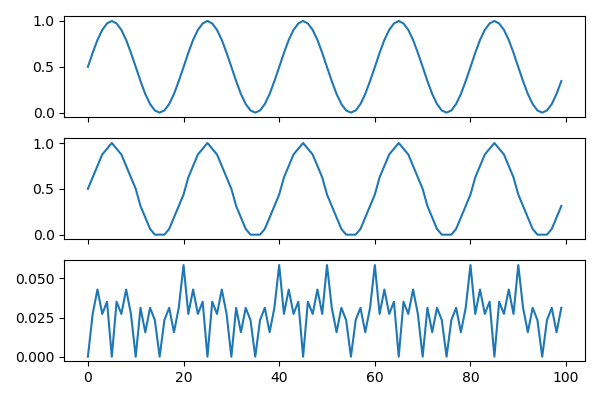

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(100)
s1 = np.array([int(x)/2**8 for x in 2**8*(np.sin(2.0*np.pi*t*0.05) + 1)/2])
s2 = np.array([int(x)/2**4 for x in 2**4*(np.sin(2.0*np.pi*t*0.05) + 1)/2])
fig, ax = plt.subplots(3, figsize=(6, 4), tight_layout=True, sharex=True)
ax[0].plot(t, s1)
ax[1].plot(t, s2)
ax[2].plot(t, np.abs(s2-s1));

### Codificación de fuente

Tarea: Convertir el diccionario del cuantizador en un **código de largo variable** 

Objetivo: Que la señal sea más eficiente de transmitir


### Codificación de canal

Tarea: Robustecer el código 

Objetivo: Que el código puede transmitirse sin errores

## Compresión y codificación

> Codificar la información usando "menos bits" que la representación original


La compresión puede ser de tipo
- *Lossless* (sin pérdidas): Los datos originales pueden reconstruirse perfectamente
- *Lossy* (con pérdidas): Se reconstruye una versión aproximada de los datos originales

Si usamos cuantización entonces estamos asumiendo pérdidas


## Compresión de imágenes

- Las tres redundancias:
    -  **Redundancia interpixel (transformación)** Alta correlación entre píxeles vecinos 
    - **Redundancia psicovisual (cuantización):** El ojo humano no puede resolver más de 32 niveles de grises:
    - **Redundancia de codificación:** Algunos tonos son más comunes que otros 
 

¿Cómo explotamos esto para reducir el tamaño de una imagen?

Más componentes descartados: mayor compresión, y peor la calidad



1. Cuantización escalar
1. Codificación de Huffman



##  Algoritmo Joint Photographic Experts Group (JPEG)

> Es un algoritmo de compresión con pérdidas (lossy) para imágenes digitales ampliamente utilizado


<img src="../images/JPEG.svg" width="800"> 

### Primer paso

Se convierte la imagen de RGB a YCbCr

Luego se reduce la resolución de los canales chroma con respecto al canal de luminancia

<img src="../images/422.jpg" width="600">

Al hacer esto explota una característica del sistema visual humano

> Somos más sensibles a la iluminación que al color

Ejemplo:

<IPython.core.display.Javascript object>


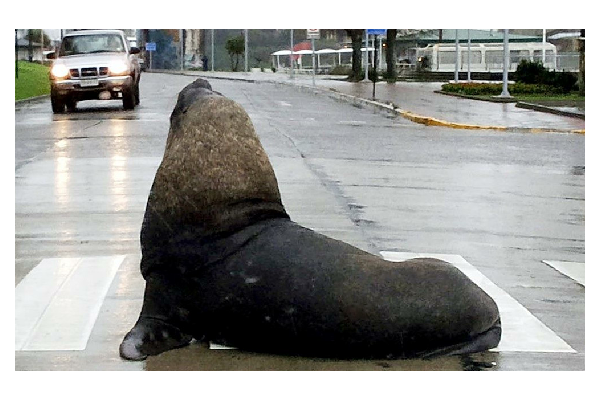

interactive(children=(SelectionSlider(description='Niveles de Y', index=8, options=(1, 2, 4, 8, 16, 32, 64, 12…

In [2]:
import cv2
from ipywidgets import interact, SelectionSlider, IntSlider

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
im = cv2.imread("../images/lobo.jpg")

def update(q_Y, q_C):
    ax.cla(); ax.axis('off')
    # Transformar a YCrCb
    im_ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    Y, Cb, Cr = im_ycrcb.T
    # Cuantizar Y y Cb/Cr por separado
    Y_q = np.round(Y*float(q_Y/255))*255.0/q_Y
    Cb_q = np.round(Cb*float(q_C/255))*255.0/q_C
    Cr_q = np.round(Cr*float(q_C/255))*255.0/q_C
    # Juntar y convertir en RGB
    im_ycrcb = np.stack((Y_q, Cb_q, Cr_q)).T
    rgb = cv2.cvtColor(im_ycrcb.astype('uint8'), cv2.COLOR_YCrCb2RGB)    
    ax.imshow(rgb);

interact(update, 
         q_Y=SelectionSlider(options=[1, 2, 4, 8, 16, 32, 64, 128, 256], 
                             value=256, description="Niveles de Y"),
         q_C=SelectionSlider(options=[1, 2, 4, 8, 16, 32, 64, 128, 256], 
                             value=256, description="Niveles de C"));

### Segundo paso

Separar la imagen en bloques disjuntos de 8x8 píxeles

Cada bloque se lleva al dominio de la frecuencia usando la transformada discreta coseno


#### Discrete Cosine Transform (DCT)

Sea una señal discreta y bidimensional $g[n_1, n_2]$ con índices $n_1 \in [0, N_1-1]$ y $n_2 \in [0, N_2-1]$ su DCT es 

$$
G_C[k_1, k_2] = \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} 4 g[n_1, n_2] \cos \left ( \frac{\pi k_1}{2N_1}(2n_1+1)  \right) \cos \left ( \frac{\pi k_2}{2N_2}(2n_2+1)  \right) 
$$
y su inversa

$$
g[n_1, n_2] = \frac{1}{N_1 N_2}\sum_{k_1=0}^{N_1-1} \sum_{k_2=0}^{N_2-1} w[k_1]w[k_2]G[k_1, k_2] \cos \left ( \frac{\pi k_1}{2N_1}(2n_1+1)  \right) \cos \left ( \frac{\pi k_2}{2N_2}(2n_2+1)  \right), 
$$

donde 
$$
w[k] =\begin{cases}
1/2 & \text{ssi} ~~ k=0\\
1 & \text{ssi} ~~ k \neq 0
\end{cases} 
$$

La DCT bidimensional:
- se puede descomponer en 2 aplicaciones de la DCT 1D
- es lineal, y cumple el principio de conservación de energía

> Podemos llevar una imagen al espacio de frecuencias sin pérdida de información


- es equivalente a la DFT de una señal "simetricamente extendida":

$$
y[k] =\begin{cases}
x[k] & \text{ssi} ~~ k<N\\
x[2N-1-k] & \text{ssi} ~~ N \leq k < 2N - 1 
\end{cases} 
$$
- Es decir que podemos usar el algoritmo FFT para calcular eficientemente la DCT

**Ojo:** La convolución en espacio original no es multiplicación en el espacio DCT


#### Ejemplo de imagen simetricamente extendida (la DCT no tiene artefactos de borde):

<IPython.core.display.Javascript object>


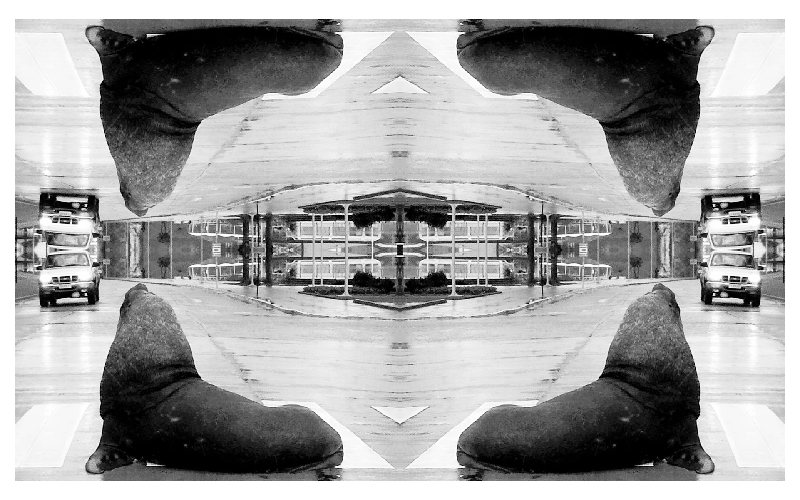

In [3]:
im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)[:, :, 0]
im_bw_sym = np.hstack((im_bw, np.fliplr(im_bw)))
im_bw_sym = np.vstack((np.flipud(im_bw_sym), im_bw_sym))
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.axis('off')
ax.imshow(im_bw_sym, cmap=plt.cm.Greys_r);

#### Ejemplo: Transformación de una imagen usando DCT en bloques de 8x8

In [4]:
from scipy import fftpack

DCT2 = lambda g, norm='ortho': fftpack.dct( fftpack.dct(g, axis=0, norm=norm), axis=1, norm=norm)
IDCT2 = lambda G, norm='ortho': fftpack.idct( fftpack.idct(G, axis=0, norm=norm), axis=1, norm=norm)

imsize = im_bw.shape
dct_matrix = np.zeros(shape=imsize)

for i in range(0, imsize[0], 8):
    for j in range(0, imsize[1], 8):
        dct_matrix[i:(i+8),j:(j+8)] = DCT2(im_bw[i:(i+8),j:(j+8)] )

¿Cómo se ven uno a uno la DCT de los bloques?

<IPython.core.display.Javascript object>


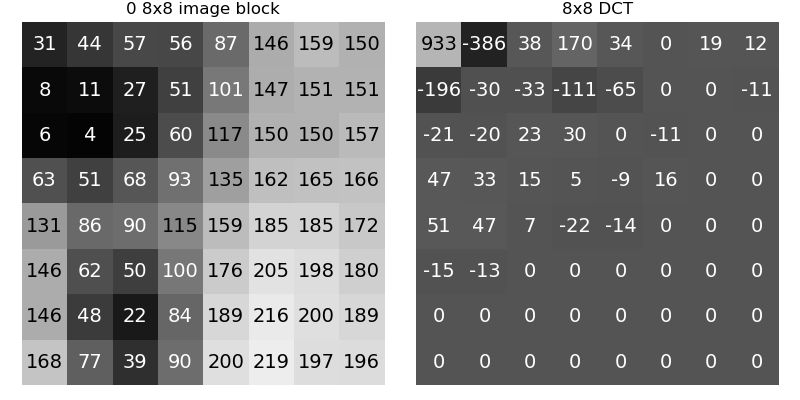

interactive(children=(IntSlider(value=0, description='Bloque'), Output()), _dom_classes=('widget-interact',))

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)

def plot_values(ax, tile, fontsize=14):
    mid = (tile.max() + tile.min())/2.
    for i in range(8):
        for j in range(8):
            label = tile[i, j]
            color = 'black' if label > mid else 'white'
            ax.text(j, i, int(label), fontsize=fontsize, 
                    color=color, ha='center', va='center')
            
            
def update(block_idx=1):
    for ax_ in ax:
        ax_.cla(); ax_.axis('off')
    # Bloque de 8x8
    tile = im_bw[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[0].imshow(tile, cmap=plt.cm.Greys_r, vmin=im_bw.min(), vmax=im_bw.max())
    ax[0].set_title("%d 8x8 image block" %(block_idx)); 
    plot_values(ax[0], tile)
    # DCT 8x8
    tile = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[1].imshow(tile, cmap=plt.cm.Greys_r, vmin=dct_matrix.min(), vmax=dct_matrix.max())
    ax[1].set_title("8x8 DCT")
    plot_values(ax[1], tile)

interact(update, block_idx=IntSlider(min=0, max=100, value=0, description="Bloque"));

Una imagen tiene mucha correlación entre sus píxeles vecinos

> Al llevarla al espacio de frecuecia esta información se concentra en el centro del espectro (esquina superior izquierda)

Notemos que muchos de los coeficientes de alta frecuencia de la DCT son cero

> La DCT ha disminuido la redundancia en la información


### Tercer paso

Cuantizar cada matriz DCT y reducir la "cantidad de valores posibles"

> La cuantización es una operación de redondeo o truncamiento

#### Cuantización escalar

Se define por en forma general como: 
- número de niveles $L$, 
- $L+1$ fronteras de decisión $d_i$ 
- $L$ valor de las representaciones $r_i$

$$
\begin{equation}
    Q(x)=
    \begin{cases}
      r_0, & x \in [d_0, d_1) \\
      r_1, & x \in [d_1, d_2) \\
      \vdots & \vdots \\
      r_i, & x \in [d_i, d_{i+1}) \\
      \vdots & \vdots \\
      r_{L-1}& x \in [d_{L-1}, d_{L}) \\
    \end{cases}
\end{equation}
$$

#### Cuantización uniforme

Es un caso particular de cuantización uniforme donde la diferencia entre los niveles $q$ es constante

Si $d_0 = -V$ y $d_L = V$, una cuantización uniforme de $L$ niveles sería

$$
q = \frac{2V}{L}
$$

$$
d_{i} = d_{i-1} + q  = d_0 + i q = -V + i \frac{2V}{L}
$$
y el valor de representación es el punto medio de cada nivel
$$
r_i = \frac{1}{2} (d_i + d_{i+1}) = -d_0 + \frac{2i+1}{2} \Delta = -V + (2i+1) \frac{V}{L}
$$ 

También podríamos definir $\Delta$ y usar la fórmula

$$
x_q = -V + \frac{q}{2} + q\cdot \text{floor}\left(\frac{x+V}{q} \right)
$$
 


#### Error de cuantización

Es la distancia entre el valor real y su versión cuantizada
$$
d_c = \|Q(x) -x\|^2
$$

<IPython.core.display.Javascript object>


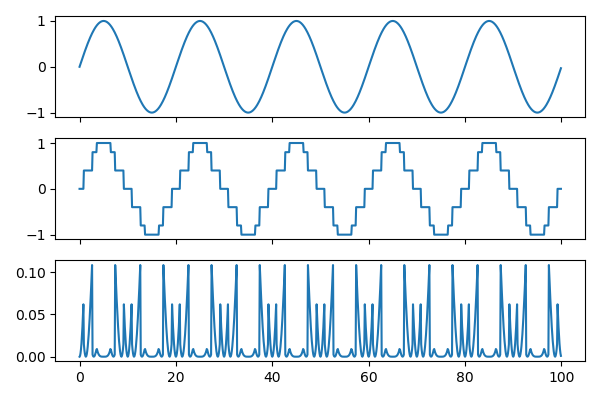

MSE: 0.01672398713553877


In [6]:
def quantize_scalar(x):
    x2 = x.copy()
    x2[(x >= -1) & (x < -0.9)] = -1.
    x2[(x >= -0.9) & (x < -0.75)] = -0.8
    x2[(x >= -0.75) & (x < -0.25)] = -0.4
    x2[(x >= -0.25) & (x < 0.25)] = 0.0
    x2[(x >= 0.25) & (x < 0.75)] = 0.4
    x2[(x >= 0.75) & (x < 0.9)] = 0.8
    x2[(x >= 0.9) ] = 1.
    return x2

def quantize_uniform(x, x_min, q):
    return x_min + q/2 + np.floor((x-x_min)/q)*q

t = np.arange(100, step=0.1)
s1 = np.sin(2.0*np.pi*t*0.05)
s2 = quantize_scalar(s1)
#s2 = quantize_uniform(s1, s1.min(), q=0.01)

fig, ax = plt.subplots(3, figsize=(6, 4), tight_layout=True, sharex=True)
ax[0].plot(t, s1)
ax[1].plot(t, s2)
ax[2].plot(t, np.power(s2-s1, 2));
print(f"MSE: {np.mean(np.power(s2-s1, 2))}")

#### Cuantización en JPEG

> JPEG cuantiza en el espacio de frecuencia

- Cada bloque de 8x8 de componentes DCT se cuantiza por separado
- El nivel de cada uno de los componentes se redondea según una matriz de cuantización Q
- Q fue diseñada tal que componentes de alta frecuencia se cuantizan en menos niveles

In [7]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

> El bloque cuantizado se obtiene como $\text{ROUND}\left(\frac{G_C}{Q}\right)$

<IPython.core.display.Javascript object>


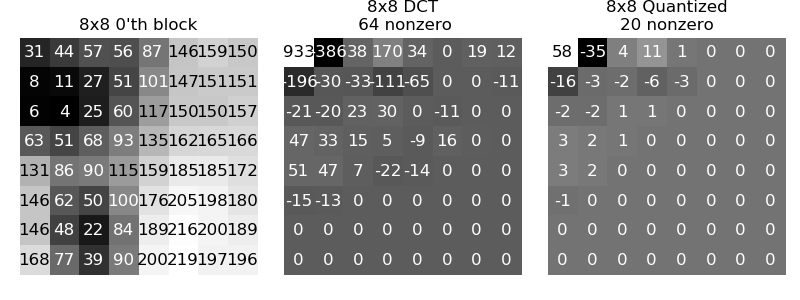

interactive(children=(IntSlider(value=0, description='Block tile'), Output()), _dom_classes=('widget-interact'…

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True)
def update(block_idx=1):
    for ax_ in ax:
        ax_.cla(); ax_.axis('off')
    tile = im_bw[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[0].imshow(tile, cmap=plt.cm.Greys_r)
    ax[0].set_title("8x8 %d'th block" %(block_idx)); 
    plot_values(ax[0], tile, fontsize=12)
    
    tile = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[1].imshow(tile, cmap=plt.cm.Greys_r)
    ax[1].set_title("8x8 DCT\n %d nonzero" %(np.count_nonzero(tile))); 
    plot_values(ax[1], tile, fontsize=12)
    
    quant = np.round(tile/Q)
    ax[2].imshow(quant, cmap=plt.cm.Greys_r)
    ax[2].set_title("8x8 Quantized\n%d nonzero" %(np.count_nonzero(quant))); 
    plot_values(ax[2], quant, fontsize=12)

interact(update, block_idx=IntSlider(min=0, max=100, value=0, description="Block tile"));

<IPython.core.display.Javascript object>


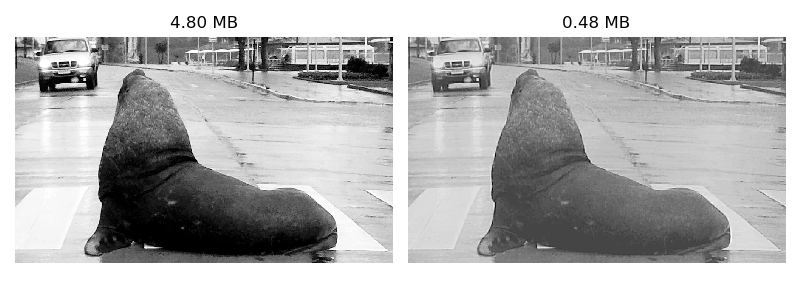

interactive(children=(FloatSlider(value=34.0, continuous_update=False, description='Nivel de compresión', max=…

In [9]:
from ipywidgets import FloatSlider

area = np.prod(im_bw.shape)
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

def update(percent):
    for ax_ in ax.ravel():
        ax_.cla(); ax_.axis('off')
    im_dct = np.zeros(imsize)
    nnz = np.zeros(dct_matrix.shape)
    if (percent < 50):
        S = 5000/percent
    else:
        S = 200 - 2*percent 
    Q_dyn = np.floor((S*Q + 50) / 100);
    Q_dyn[Q_dyn == 0] = 1
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            quant = np.round(dct_matrix[i:(i+8),j:(j+8)]/Q_dyn) 
            im_dct[i:(i+8),j:(j+8)] = IDCT2(quant)
            nnz[i, j] = np.count_nonzero(quant)
    
    ax[0].imshow(im_bw, cmap=plt.cm.Greys_r); 
    ax[0].set_title("%0.2f MB" %(area*8/1e+6))
    ax[1].imshow(im_dct, cmap=plt.cm.Greys_r); 
    ax[1].set_title("%0.2f MB" %(np.sum(nnz)*8/1e+6))
interact(update, percent=FloatSlider(min=0.01, max=99.99, step=0.01, value=34, continuous_update=False, 
                                     description="Nivel de compresión"));

### Cuarto paso

Para entender el cuarto paso necesitamos estudiar **Teoría de la Información**